# Loading packages and files

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
file_path = "Data Analyst Intern Assignment - Excel.xlsx"
user_details  = pd.read_excel(file_path,"UserDetails.csv")
cooking_sessions  = pd.read_excel(file_path,"CookingSessions.csv")
order_details  = pd.read_excel(file_path,"OrderDetails.csv")

# Data Cleaning

In [3]:
# Cleaning UserDetails
user_details.drop_duplicates(subset=['User ID'], inplace=True)
user_details['Phone'] = user_details['Phone'].str.replace(r'\D', '', regex=True)
user_details['Registration Date'] = pd.to_datetime(user_details['Registration Date'])
user_details.fillna({'Favorite Meal': 'Unknown'}, inplace=True)

# Cleaning CookingSessions
cooking_sessions.drop_duplicates(subset=['Session ID'], inplace=True)
cooking_sessions['Session Start'] = pd.to_datetime(cooking_sessions['Session Start'])
cooking_sessions['Session End'] = pd.to_datetime(cooking_sessions['Session End'])
cooking_sessions['Duration (mins)'] = (cooking_sessions['Session End'] - cooking_sessions['Session Start']).dt.total_seconds() / 60
cooking_sessions['Session Rating'] = cooking_sessions['Session Rating'].fillna(cooking_sessions['Session Rating'].mean())

# Cleaning OrderDetails
order_details.drop_duplicates(subset=['Order ID'], inplace=True)
order_details['Order Date'] = pd.to_datetime(order_details['Order Date'])
order_details['Amount (USD)'] = order_details['Amount (USD)'].fillna(0)
order_details.loc[order_details['Order Status'] == 'Cancelled', 'Amount (USD)'] = 0
order_details['Rating'] = order_details['Rating'].fillna(order_details['Rating'].mean())


# Data Merging

In [ ]:
# Merge UserDetails with CookingSessions
user_cooking_data = pd.merge(user_details, cooking_sessions, on='User ID', how='left')

# Merge the result with OrderDetails
master_data = pd.merge(user_cooking_data, order_details, on=['User ID', 'Dish Name', 'Meal Type', 'Session ID'], how='left')

# Relationship Between Cooking Sessions and User Orders:
Compare Dish Name in CookingSessions and OrderDetails to see if users order dishes they cooked.
Analyze if highly rated cooking sessions influence the number or frequency of orders.

In [5]:
cooking_to_order = master_data.groupby('Dish Name').agg({
    'Session Rating': 'mean',
    'Order ID': 'count'
}).rename(columns={'Order ID': 'Order Count'})

cooking_to_order = cooking_to_order.sort_values(by='Order Count', ascending=False)
print(cooking_to_order)

                 Session Rating  Order Count
Dish Name                                   
Grilled Chicken        4.775000            4
Spaghetti              4.625000            4
Caesar Salad           4.366667            3
Pancakes               4.400000            2
Veggie Burger          4.350000            2
Oatmeal                4.100000            1


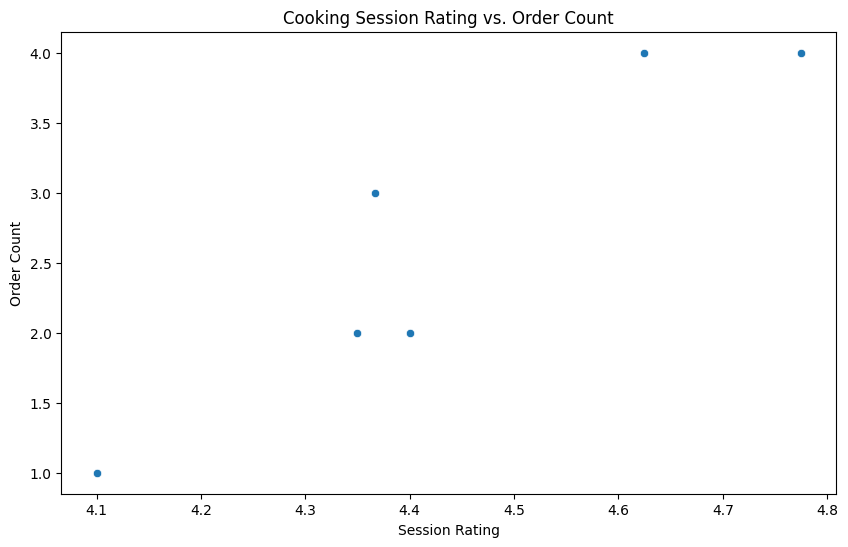

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Session Rating', y='Order Count', data=cooking_to_order.reset_index())
plt.title('Cooking Session Rating vs. Order Count')
plt.xlabel('Session Rating')
plt.ylabel('Order Count')
plt.show()

# Popular Dishes:
Identify dishes with the highest number of orders and high session ratings.

In [7]:
popular_dishes = master_data['Dish Name'].value_counts().head(10)
print(popular_dishes)

Dish Name
Spaghetti          4
Grilled Chicken    4
Caesar Salad       3
Pancakes           2
Veggie Burger      2
Oatmeal            1
Name: count, dtype: int64


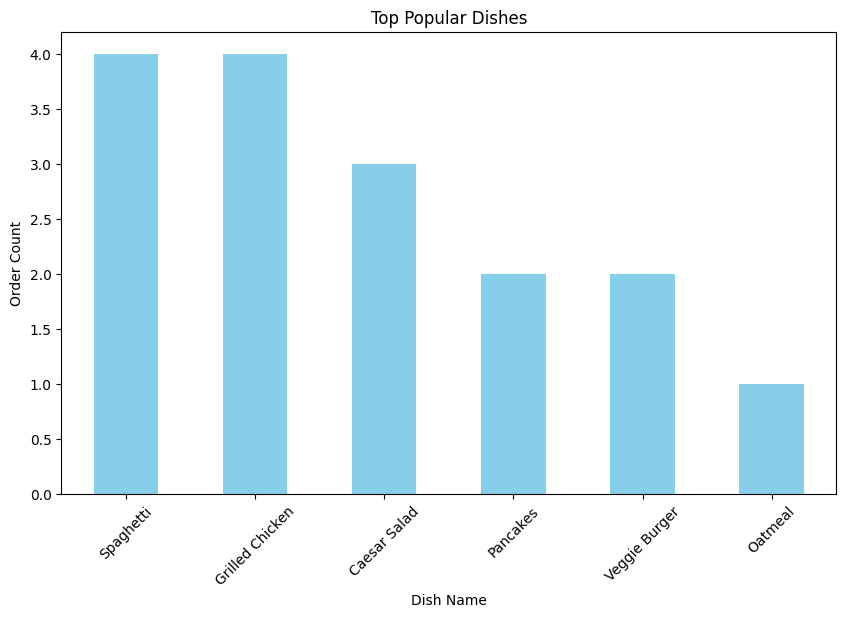

In [8]:
popular_dishes.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top Popular Dishes')
plt.xlabel('Dish Name')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.show()

# Demographic Analysis:
Study how Age, Location, and Favorite Meal influence:
Number of cooking sessions.
Order frequency.
Popular meal types (e.g., breakfast, lunch, dinner).

In [9]:
age_group_orders = master_data.groupby(pd.cut(user_details['Age'], bins=[0, 18, 30, 50, 100]),observed=True).agg({'Total Orders': 'sum'})
print(age_group_orders)

location_analysis = master_data.groupby('Location').agg({'Total Orders': 'sum'}).sort_values(by='Total Orders', ascending=False)
print(location_analysis.head())

          Total Orders
Age                   
(18, 30]            46
(30, 50]            69
               Total Orders
Location                   
Chicago                  45
New York                 36
Los Angeles              24
San Francisco            20
Seattle                  18


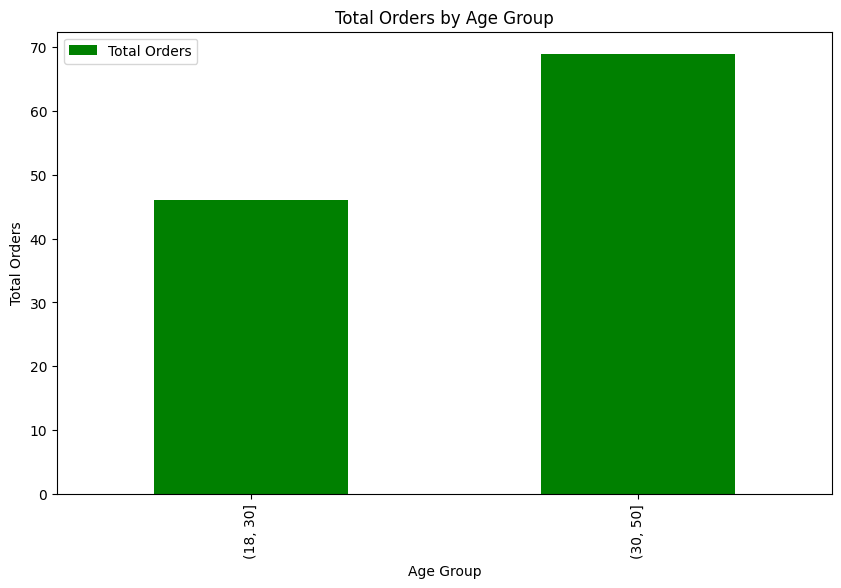

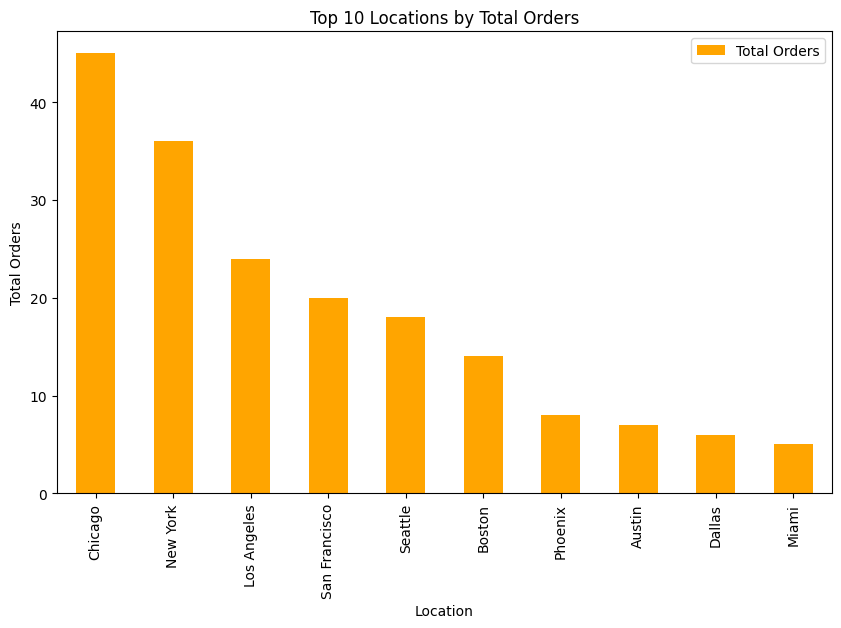

In [10]:
age_group_orders.plot(kind='bar', figsize=(10, 6), color='green')
plt.title('Total Orders by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Orders')
plt.show()

location_analysis.head(10).plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Top 10 Locations by Total Orders')
plt.xlabel('Location')
plt.ylabel('Total Orders')
plt.show()

# Trends in User Behavior:
Determine if users are more active at certain times (Time of Day).

In [11]:
master_data['Day of Week'] = master_data['Order Date'].dt.day_name()
order_trends = master_data.groupby(['Day of Week', 'Meal Type']).agg({'Order ID': 'count'}).unstack().fillna(0)
print(order_trends)

             Order ID             
Meal Type   Breakfast Dinner Lunch
Day of Week                       
Friday            1.0    1.0   0.0
Monday            1.0    1.0   0.0
Saturday          0.0    1.0   1.0
Sunday            0.0    2.0   2.0
Thursday          1.0    1.0   0.0
Tuesday           0.0    1.0   1.0
Wednesday         0.0    1.0   1.0


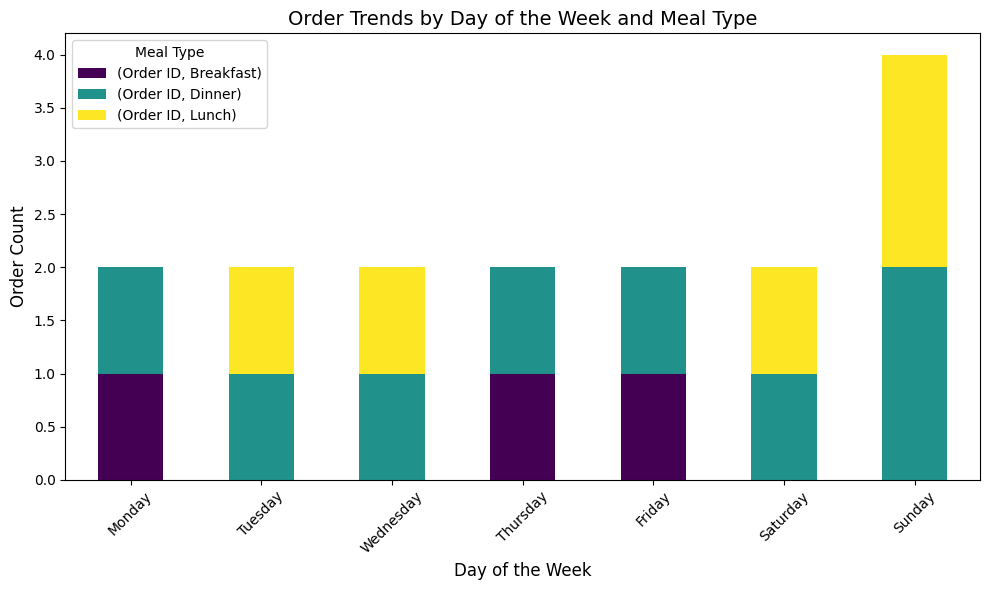

In [12]:
# Ensure the index (Day of Week) is sorted in natural order
order_trends = order_trends.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create the stacked bar chart
order_trends.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Add chart title and labels
plt.title('Order Trends by Day of the Week and Meal Type', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Order Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Meal Type', fontsize=10)
plt.tight_layout()

# Show the chart
plt.show()

# User Behavior Analysis
* Order Frequency:

Calculate the average number of orders per user.
Identify power users (users with significantly higher orders than average).
Analyze the gap between consecutive orders for frequent and infrequent users.


In [13]:
order_frequency = master_data.groupby('User ID').agg({'Order ID': 'count'}).rename(columns={'Order ID': 'Order Count'})
avg_orders = order_frequency['Order Count'].mean()
power_users = order_frequency[order_frequency['Order Count'] > avg_orders * 1]
print("Aveerage User order frequency", avg_orders)
print("Power Users:", power_users)

Aveerage User order frequency 1.6
Power Users:          Order Count
User ID             
U001               3
U002               3
U003               3
U004               2
U005               2


* Session Engagement:

Analyze the proportion of users who attend cooking sessions but don’t place orders.
Identify users who only attend sessions for specific meal types (e.g., breakfast or desserts).

In [14]:
session_only_users = master_data[master_data['Order ID'].isna()]['User ID'].nunique()
print(f"Users attending sessions without orders: {session_only_users}")

Users attending sessions without orders: 2


# Dish-Level Insights
* Dish Loyalty:

Check how often users reorder the same dish.
Calculate the average reorder rate for each dish

In [15]:
dish_reorders = master_data.groupby('Dish Name').agg({'Order ID': 'count', 'User ID': 'nunique'})
dish_reorders['Reorder Rate'] = dish_reorders['Order ID'] / dish_reorders['User ID']
print(dish_reorders.sort_values(by='Reorder Rate', ascending=False).head())

                 Order ID  User ID  Reorder Rate
Dish Name                                       
Caesar Salad            3        3           1.0
Grilled Chicken         4        4           1.0
Oatmeal                 1        1           1.0
Pancakes                2        2           1.0
Spaghetti               4        4           1.0


* Unpopular Dishes:

Identify dishes with high cooking session ratings but low order counts.
Explore potential reasons (e.g., pricing, availability).

In [16]:
unpopular_dishes = cooking_to_order[cooking_to_order['Order Count'] < 2]
print("Unpopular Dishes:", unpopular_dishes)

Unpopular Dishes:            Session Rating  Order Count
Dish Name                             
Oatmeal               4.1            1


# Revenue Analysis
* Top Revenue-Generating Users:

Identify users contributing the most revenue.
Compare revenue distribution across locations.

In [17]:
top_revenue_users = master_data.groupby('User ID')['Amount (USD)'].sum().sort_values(ascending=False).head(10)
print("Top Revenue-Generating Users:", top_revenue_users)

Top Revenue-Generating Users: User ID
U001    35.0
U003    32.0
U002    31.0
U005    22.5
U004    21.5
U007    14.0
U006    13.0
U008    11.0
U009     0.0
U010     0.0
Name: Amount (USD), dtype: float64


# Session-Level Insights
* Session Duration vs. Rating:

Explore if longer cooking sessions lead to higher ratings.

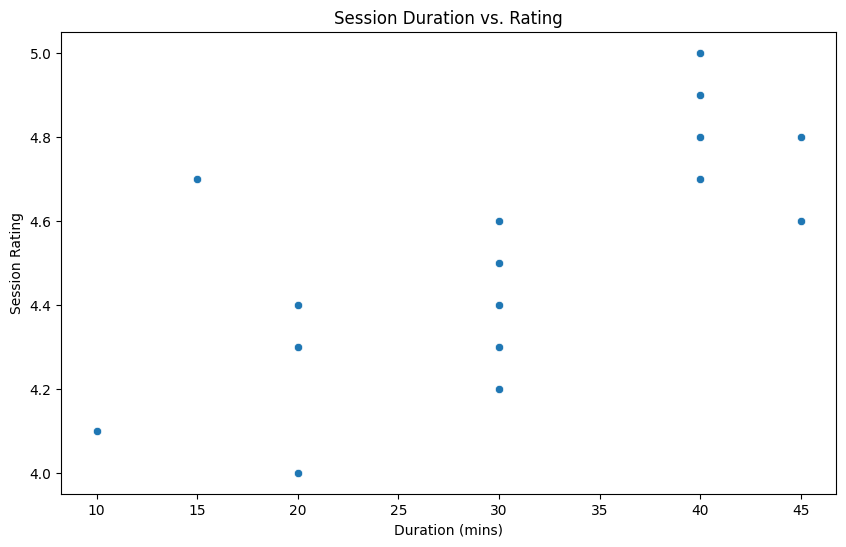

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration (mins)', y='Session Rating', data=cooking_sessions)
plt.title('Session Duration vs. Rating')
plt.show()

* Meal Type Popularity:

Analyze which meal types are most commonly chosen for cooking sessions.
Compare session ratings across meal types

In [19]:
meal_type_popularity = cooking_sessions['Meal Type'].value_counts()
print("Meal Type Popularity:", meal_type_popularity)

Meal Type Popularity: Meal Type
Dinner       8
Lunch        5
Breakfast    3
Name: count, dtype: int64


# Time-Based Insights
* Order Timing Patterns:

Analyze which times of day have the highest number of orders.
Identify peak times for specific meal types.

In [20]:
order_timing = master_data.groupby('Time of Day').agg({'Order ID': 'count'})
print("Order Timing Patterns:", order_timing)

Order Timing Patterns:              Order ID
Time of Day          
Day                 5
Morning             3
Night               8


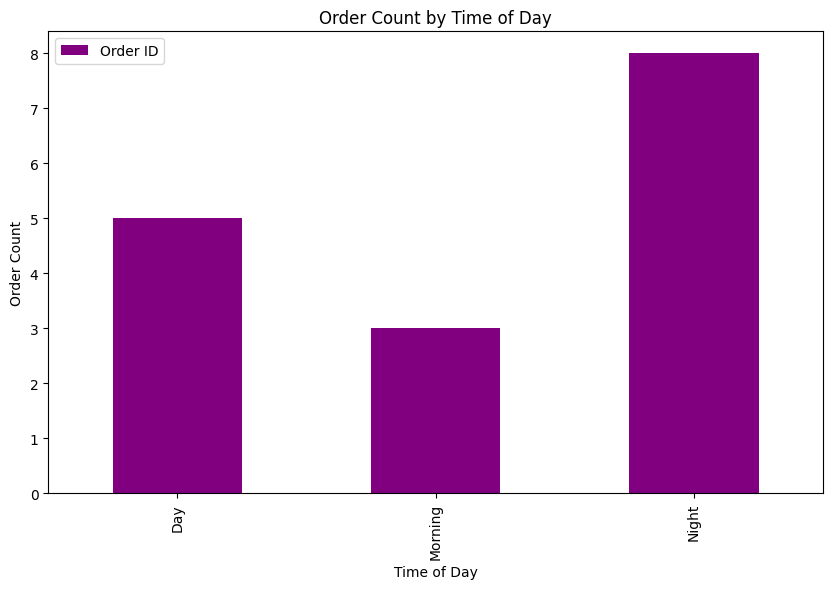

In [21]:
order_timing.plot(kind='bar', figsize=(10, 6), color='purple')
plt.title('Order Count by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Order Count')
plt.show()

* Weekly Trends:

Identify the most active days for cooking sessions and orders.

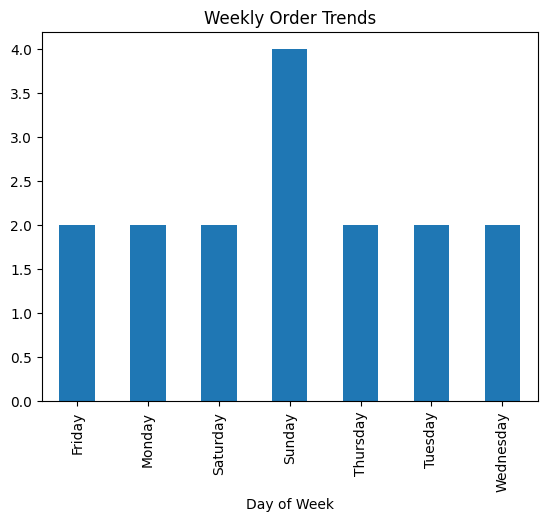

In [22]:
weekly_trends = master_data.groupby('Day of Week')['Order ID'].count()
weekly_trends.plot(kind='bar', title='Weekly Order Trends')
plt.show()

# Advanced Behavioral Insights
* Conversion Rate:

Calculate the percentage of users converting from cooking sessions to orders.
python
Copy code


In [23]:
conversion_rate = master_data[~master_data['Order ID'].isna()]['User ID'].nunique() / master_data['User ID'].nunique()
print(f"Conversion Rate: {conversion_rate:.2%}")

Conversion Rate: 80.00%


* Rating Analysis:

Check if higher session or order ratings correlate with user retention or higher spending

In [24]:
rating_spending = master_data.groupby('Rating').agg({'Amount (USD)': 'mean'})
print("Average Spending by Rating:", rating_spending)

Average Spending by Rating:           Amount (USD)
Rating                
4.000000         10.25
4.285714         11.75
5.000000         13.50


Meal Type      Breakfast  Dinner  Lunch
Location                               
Austin               0.0     1.0    0.0
Boston               0.0     1.0    0.0
Chicago              1.0     1.0    1.0
Los Angeles          1.0     1.0    1.0
Miami                0.0     0.0    1.0
New York             1.0     2.0    0.0
San Francisco        0.0     1.0    1.0
Seattle              0.0     1.0    1.0


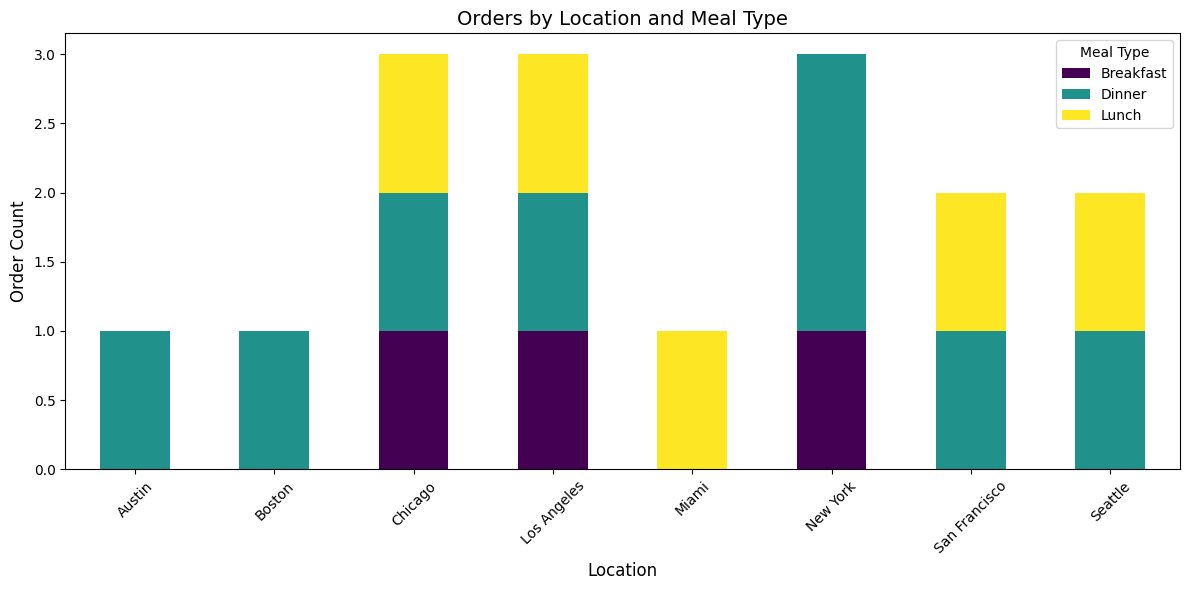

In [25]:
# Group data by Location and Meal Type, and count the number of orders
location_meal_type = master_data.groupby(['Location', 'Meal Type'])['Order ID'].count().unstack().fillna(0)

# Print the resulting DataFrame
print(location_meal_type)

# Plot a stacked bar chart for Location and Meal Type
location_meal_type.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

# Add chart title and labels
plt.title('Orders by Location and Meal Type', fontsize=14)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Order Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Meal Type', fontsize=10)
plt.tight_layout()

# Show the chart
plt.show()

Dish Name      Caesar Salad  Grilled Chicken  Oatmeal  Pancakes  Spaghetti  \
Location                                                                     
Austin                  0.0              1.0      0.0       0.0        0.0   
Boston                  0.0              0.0      0.0       0.0        1.0   
Chicago                 0.0              1.0      0.0       1.0        0.0   
Los Angeles             1.0              0.0      1.0       0.0        1.0   
Miami                   0.0              0.0      0.0       0.0        0.0   
New York                0.0              1.0      0.0       1.0        1.0   
San Francisco           1.0              0.0      0.0       0.0        1.0   
Seattle                 1.0              1.0      0.0       0.0        0.0   

Dish Name      Veggie Burger  
Location                      
Austin                   0.0  
Boston                   0.0  
Chicago                  1.0  
Los Angeles              0.0  
Miami                    1.0  
Ne

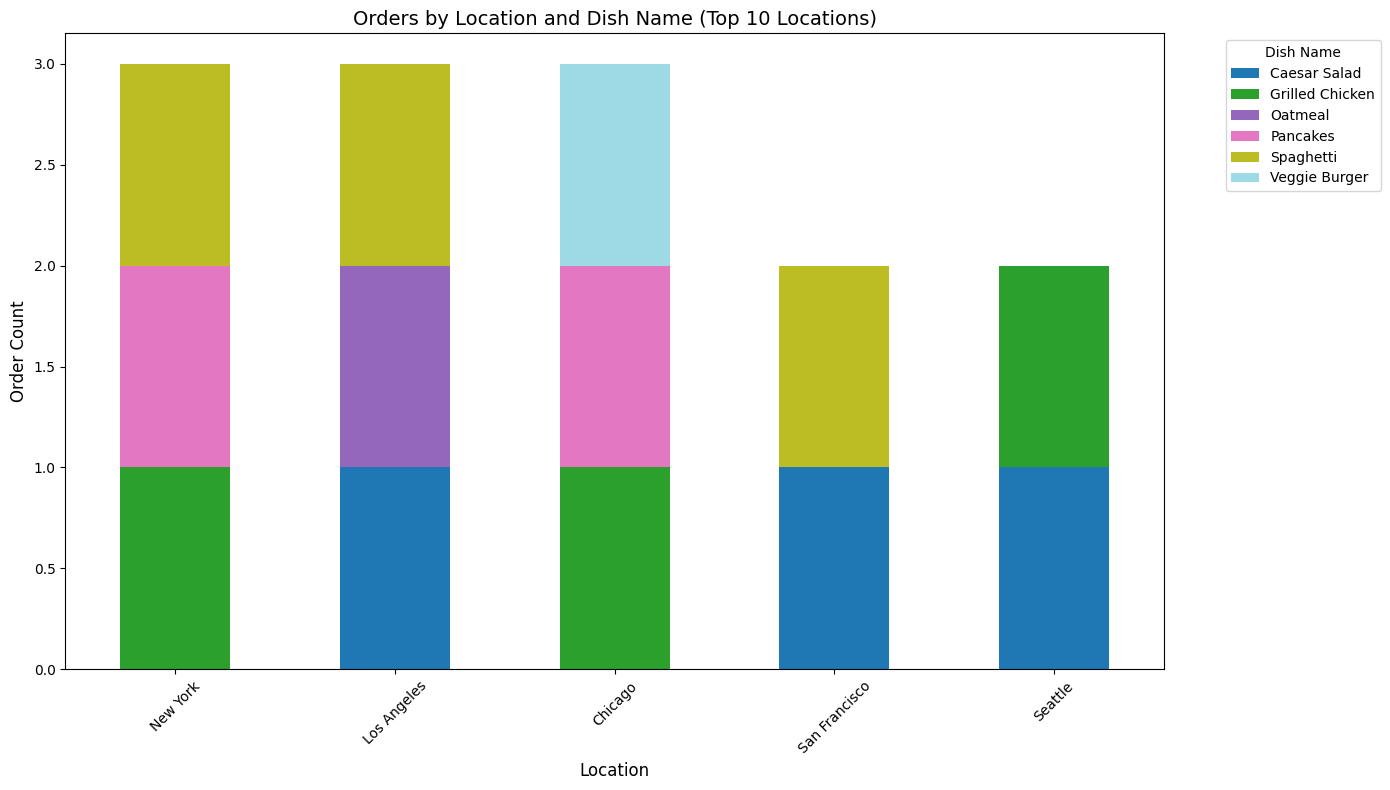

In [27]:
# Group data by Location and Dish Name, and count the number of orders
location_dish = master_data.groupby(['Location', 'Dish Name'])['Order ID'].count().unstack().fillna(0)

# Print the resulting DataFrame
print(location_dish)

# To visualize, show the top 10 locations with the most dish variety/orders
top_locations = master_data['Location'].value_counts().head(5).index
location_dish_top = location_dish.loc[top_locations]

# Plot a stacked bar chart for Location and Dish Name
location_dish_top.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

# Add chart title and labels
plt.title('Orders by Location and Dish Name (Top 10 Locations)', fontsize=14)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Order Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Dish Name', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the chart
plt.show()